## Import Data and Create Column Names
1. Import data as a table
2. Add column names into the table

In [1]:
T = readtable('C:\Users\jerem\Documents\Python Scripts\Scania\clean_data.csv');

T.Properties.VariableNames = {'KVSV1', 'OTGT1', 'OTGT6', 'OTSV1', 'QV11', 'TV11', 'TV12', 'TV_Cmd'};

## Create mini batch
Input Command: TV_Cmd    <br>
Input 3-way valve: OTSV1 <br>
Output Temp: TV12

In [39]:
mini_batch_train = T(1:5000:end, :);
mini_batch_test  = T(2:5000:end, :);

u_train = table2array(mini_batch_train(:, 4));   % OTSV1
y_train = table2array(mini_batch_train(:, 7));   % TV12

u_test = table2array(mini_batch_test(:, 4));   % OTSV1
y_test = table2array(mini_batch_test(:, 7));   % TV12

## Create iddata object for Training and Testing
data = iddata(*output*, *input*, *sampling time*)

In [41]:
Ts = 0.002;   % 2ms

%% Training Data
data_train = iddata(y, u, Ts);

data_train.Name = 'mini_batch_train';
data_train.TimeUnit = 'seconds';

data_train.InputName = 'OTSV1';   data_train.InputUnit = 'Percentage';
data_train.OutputName = 'TV12';   data_train.OutputUnit = 'Celsius';

%% Testing Data
data_test = iddata(y, u, Ts);

data_test.Name = 'mini_batch_test';
data_test.TimeUnit = 'seconds';

data_test.InputName = 'OTSV1';   data_test.InputUnit = 'Percentage';
data_test.OutputName = 'TV12';   data_test.OutputUnit = 'Celsius';

%% Print Data
get(data_train)


ans = 

  struct with fields:

              Domain: 'Time'
                Name: 'mini_batch_train'
          OutputData: [323x1 double]
                   y: 'Same as OutputData'
          OutputName: {'TV12'}
          OutputUnit: {'Celsius'}
           InputData: [323x1 double]
                   u: 'Same as InputData'
           InputName: {'OTSV1'}
           InputUnit: {'Percentage'}
              Period: Inf
         InterSample: 'zoh'
                  Ts: 0.0020
              Tstart: []
    SamplingInstants: [323x0 double]
            TimeUnit: 'seconds'
      ExperimentName: 'Exp1'
               Notes: {}
            UserData: []




## Check Nonlinearity

In [42]:
advice(data_train, 'nonlinearity')

There is an indication of nonlinearity in the data.
A nonlinear ARX model of order [4 4 1] and treepartition nonlinearity estimator 
performs better prediction of output than the corresponding ARX model of the 
same order. Consider using nonlinear models, such as IDNLARX, or IDNLHW. You 
may also use the "isnlarx" command to test for nonlinearity with more options.




## Plot Input-Output

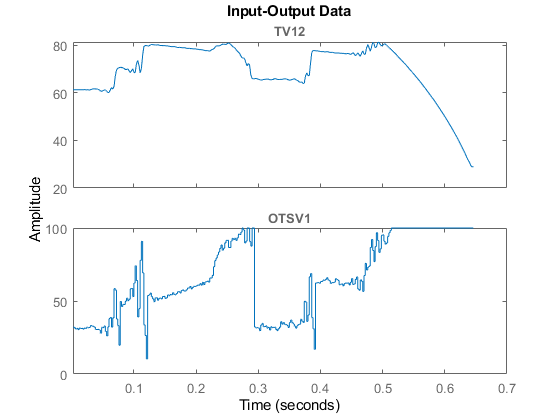

In [64]:
plot(data_train)

## System Identification: Transfer Function Model
sysTF = tfest(*data*, *Num of Poles*, *Num of Zeros*)

### Set estimation options

In [82]:
opt = tfestOptions;
opt.InitializeMethod = 'all';
opt.Focus = 'prediction';
opt.SearchOptions.MaxIterations = 50; 
opt.Display = 'on';

> In idoptions/tfest/checkFocus_ (line 38)
In idoptions/GenericFocus/setFocus_ (line 71)
In idoptions.PredSimFocus.set.Focus (line 20)



### Estimate TF model

In [90]:
np = 2;          % Num of pole
nz = 1;          % Num of zero
iodelay = 20.0;   % In/Out delay

sysTF = tfest(data_train, np, nz, opt)


sysTF =
 
  From input "OTSV1" to output "TV12":
       58 s + 2.611e06
  --------------------------
  s^2 + 5.935e05 s + 2.47e06
 
Continuous-time identified transfer function.

Parameterization:
   Number of poles: 2   Number of zeros: 1
   Number of free coefficients: 4
   Use "tfdata", "getpvec", "getcov" for parameters and their uncertainties.

Status:                                                      
Estimated using TFEST on time domain data "mini_batch_train".
Fit to estimation data: -46.02%                              
FPE: 286.1, MSE: 275.7                                       



### Advice on the estimated model

In [91]:
advice(sysTF, data_test)

                                                                                                                                                                                                                                                                                                                              
The model may be improved if more iterations in the search are used. Try, for 
example:
   Options = sysTF.Report.OptionsUsed;
   Options.SearchOptions.MaxIterations = 60; 
   sysTF = pem(sysTF, mini_batch_train, Options)                                                                                                 
                                                                                                                                                                                                                                                                                                                              
There is no indication of significant error

### Perform Residual Analysis

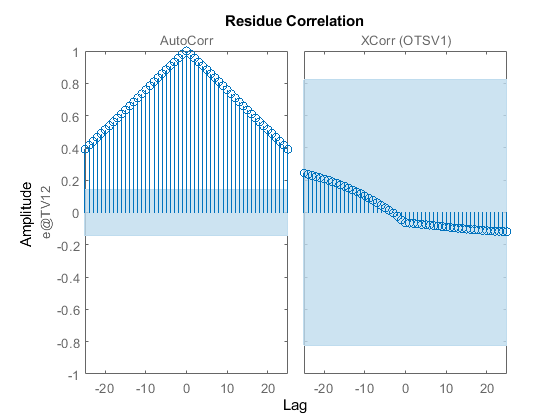

In [92]:
resid(data_test,sysTF)

## System Identification: State Space Model
sysSS = ssest(*data*, *Num of Poles*, *Num of Zeros*)

## System Identification: Transfer Function Model
sysTF = tfest(*data*, *Num of Poles*, *Num of Zeros*)### Set estimation options

### Set estimation options

In [77]:
opt = ssestOptions;
opt.InitializeMethod = 'auto';
opt.Focus = 'prediction';
opt.SearchOptions.MaxIterations = 50; 
opt.Display = 'on';

### Estimate TF model

In [78]:
nx = 2
sysSS = ssest(data_train, nx, opt)


nx =

     2


sysSS =
  Continuous-time identified state-space model:
      dx/dt = A x(t) + B u(t) + K e(t)
       y(t) = C x(t) + D u(t) + e(t)
 
  A = 
           x1      x2
   x1   3.781  -1.257
   x2    37.1  -94.02
 
  B = 
         OTSV1
   x1  0.06481
   x2    5.256
 
  C = 
            x1     x2
   TV12  503.8   -2.5
 
  D = 
         OTSV1
   TV12      0
 
  K = 
         TV12
   x1   1.643
   x2  -9.475
 
Parameterization:
   FREE form (all coefficients in A, B, C free).
   Feedthrough: none
   Disturbance component: estimate
   Number of free coefficients: 10
   Use "idssdata", "getpvec", "getcov" for parameters and their uncertainties.

Status:                                                      
Estimated using SSEST on time domain data "mini_batch_train".
Fit to estimation data: 94.26% (prediction focus)            
FPE: 0.4473, MSE: 0.4257                                     



In [89]:
[b, a] = ss2tf(sysSS.A, sysSS.B, sysSS.C, sysSS.D);
systf = tf(b, a)


systf =
 
      19.51 s - 216
  ---------------------
  s^2 + 90.24 s - 308.8
 
Continuous-time transfer function.




### Advice on the estimated model

In [79]:
advice(sysSS, data_test)

                                                                                                                                                                                                                                           
The model may be improved if more iterations in the search are used. Try, for 
example:
   Options = sysSS.Report.OptionsUsed;
   Options.SearchOptions.MaxIterations = 60; 
   sysSS = pem(sysSS, mini_batch_train, Options)              
                                                                                                                                                                                                                                           
There is a very strong indication that the dynamics of the model is not 
adequately described.                                                                                                                                             
                                                        

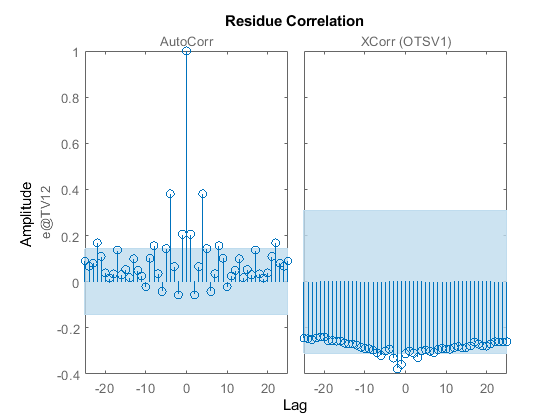

In [80]:
resid(data_test,sysSS)